In [13]:
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import Imputer
import sys

data = pd.read_csv('mirnovo_dre_feature_table.txt', sep='\t')

# replace YES with 1 and NO with 0 and store to 'y'
label_mapping = {'YES': 1, 'NO': 0}
data = data.replace({'hits_on_mature_miR': label_mapping})


# drop features - not to be used for prediction
data = data.drop(['cluster', 'ident2rev_compl_clust', 'num_mism_in_MB', 'num_mismatches_8mer'], axis=1)


# print(data.columns)
# sys.exit()
y = data['hits_on_mature_miR']
# normalise data
data = (data - data.min()) / (data.max() - data.min())

# imputing missing values
# fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
# imputed_DF = pd.DataFrame(fill_NaN.fit_transform(data))
# imputed_DF.columns = data.columns
# data.index = data.index

# data = imputed_DF

data = data.interpolate(method='spline', order=2) # interpolate missing values
#data = data.fillna(0)

data['hits_on_mature_miR'] = y



np.random.seed(1453)

# # Split X into training and test sets
sample = np.random.choice(data.index, size=int(len(data)*0.8), replace=False)
train_data, test_data = data.iloc[sample], data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))

X_train = np.array(train_data.drop('hits_on_mature_miR', axis=1))
y_train = np.array(keras.utils.to_categorical(train_data['hits_on_mature_miR'], 2)) # with softmax
# y_train = np.array(train_data['hits_on_mature_miR']) # with sigmoid

X_test = np.array(test_data.drop('hits_on_mature_miR', axis=1))
y_test = np.array(keras.utils.to_categorical(test_data['hits_on_mature_miR'], 2)) # with softmax
# y_test = np.array(test_data['hits_on_mature_miR']) # with sigmoid


print("Number of rows in X_train: ", len(X_train))
print("Number of rows in y_train: ", len(y_train))
print("Number of rows in X_test", len(X_test))
print("Number of rows in y_test", len(y_test))

Number of training samples is 4400
Number of testing samples is 1100
Number of rows in X_train:  4400
Number of rows in y_train:  4400
Number of rows in X_test 1100
Number of rows in y_test 1100


In [14]:
data.columns
# tt = pd.DataFrame(y_train)
# tt.columns = ['c0', 'c1']
# tt.loc[tt['c1'] == 1.0]
# data

Index(['avg_seq_len', 'MainBody_length', 'avg_GC_cont', 'avg_ATcont_after3p',
       'sum_all_reads', 'num_gap_bars', 'scale_rate_5p', 'len_after_MB',
       'gap_droppin_len', 'gcs', 'ats', 'cpg', 'cwf', 'ce', 'cz', 'cm2', 'cm3',
       'ct2', 'ct3', 'cl2', 'cl3', 'hits_on_mature_miR',
       'bracket-mirna-fraction', 'hairpin-size-estimate',
       'loop-mirna-distance-estimate', 'loop-size-estimate',
       'loops-in-hairpin', 'minimum-free-energy', 'mirna-bracket-discrepancy',
       'mirna-bracket-majority', 'mirna-unmatched'],
      dtype='object')

In [49]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras import regularizers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Building the model
def create_model():
    
    ## create model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.0001)))
    # model.add(Dropout(.1))
#     model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    # model.add(Dropout(.1))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))

    model.add(Dense(2, activation='softmax'))
    # model.add(Dense(1, activation='sigmoid'))
    
    ## Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model, verbose=1)
# Compiling the model
# # sgd_optim = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
# adam=keras.optimizers.Adam(lr=0.0001)
model

## Grid Search

In [55]:
from sklearn.metrics import recall_score, accuracy_score, make_scorer
# my_scorer = make_scorer(accuracy_score)

# define the grid search parameters
batch_size = [16, 32]
epochs = [10]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

Epoch 1/10
2933/2933 [==============================] - 3s 1ms/step - loss: 0.3329 - acc: 0.9114
Epoch 2/10
2933/2933 [==============================] - 0s 130us/step - loss: 0.3024 - acc: 0.9114
Epoch 3/10
2933/2933 [==============================] - 0s 125us/step - loss: 0.3009 - acc: 0.9114
Epoch 4/10
2160/2933 [=====================>........] - ETA: 0s - loss: 0.3014 - acc: 0.9116

KeyboardInterrupt: 

In [51]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.914091 using {'batch_size': 16, 'epochs': 10}
0.914091 (0.005510) with: {'batch_size': 16, 'epochs': 10}
0.914091 (0.005510) with: {'batch_size': 32, 'epochs': 10}


In [36]:
model = create_model()
# Training the model
# callbacks = [EarlyStopping(monitor='acc', patience=2)] # do not apply without checking
out = model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0, validation_split=0.1) #, callbacks=callbacks)

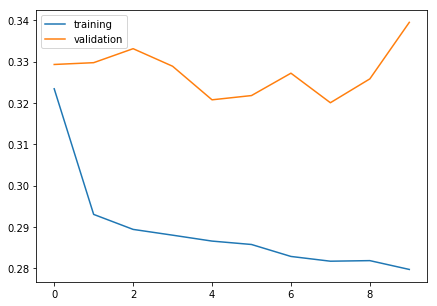

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = np.array(out.__dict__['epoch'])
acc = np.array(out.__dict__['history']['acc'])
loss = np.array(out.__dict__['history']['loss'])
val_acc = np.array(out.__dict__['history']['val_acc'])
val_loss = np.array(out.__dict__['history']['val_loss'])

f = plt.figure(figsize=(7,5))
plt.plot(epochs, loss, label='training')
plt.plot(epochs, val_loss, label='validation')
plt.legend(loc='upper left')

plt.show()
f.savefig("train_validation_loss.pdf", bbox_inches='tight')

In [38]:
# Evaluating the model on the training and testing set
train_score = model.evaluate(X_train, y_train, verbose=1)
print("\n Training Accuracy:", train_score[1])
test_score = model.evaluate(X_test, y_test, verbose=1)
print("\n Testing Accuracy:", test_score[1])

4400/4400 [==============================] - 0s 34us/step

 Training Accuracy: 0.914090909091
1100/1100 [==============================] - 0s 33us/step

 Testing Accuracy: 0.919999999783


In [39]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred = y.values.argmax

y_pred = model.predict_classes(X_test)

p = model.predict_proba(X_test)

print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
print()
TN, FP, FN, TP = confusion_matrix(np.argmax(y_test, axis=1), y_pred).ravel()
print("TP:", TP)
print("FN:", FN)
print("TN:", TN)
print("FP:", FP)
len(p)

             precision    recall  f1-score   support

          0       0.92      1.00      0.96      1012
          1       0.00      0.00      0.00        88

avg / total       0.85      0.92      0.88      1100

[[1012    0]
 [  88    0]]

TP: 0
FN: 88
TN: 1012
FP: 0


/Users/dvitsios/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1100

In [40]:
conc = pd.concat([pd.DataFrame(y_test), pd.DataFrame(p)], axis=1)
conc.columns = ['test_0', 'test_1', 'pred_0', 'pred_1']
subdf = conc.loc[conc['test_1'] == 1]
subdf.loc[subdf['pred_1'] >= 0.5]

,test_0,test_1,pred_0,pred_1
